# Basic datasets with CNNs and Keras

In [0]:
import tensorflow as tf
import os

print(tf.__version__)
print(tf.keras.__version__)
print(os.environ['COLAB_TPU_ADDR'])

1.13.1
2.2.4-tf
10.109.223.170:8470


## Data Setup

In [0]:
from tensorflow.keras.utils import to_categorical

In [0]:
# NOTE: TPU setup
# SEE: https://medium.com/tensorflow/tf-keras-on-tpus-on-colab-674367932aa0

try:
  device_name = os.environ['COLAB_TPU_ADDR']
  TPU_ADDRESS = 'grpc://' + device_name
  print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
  print('TPU not found')

Found TPU at: grpc://10.109.223.170:8470


### **CIFAR10**

In [0]:
from tensorflow.keras.datasets import cifar10

In [0]:
(cifar_train, cifar_train_labels_sparse), (cifar_test, cifar_test_labels_sparse) = cifar10.load_data()

In [0]:
cifar_train_norm = cifar_train.astype('float32') / 255
cifar_test_norm = cifar_test.astype('float32') / 255

In [0]:
cifar_train_labels = to_categorical(cifar_train_labels_sparse)
cifar_test_labels = to_categorical(cifar_test_labels_sparse)

In [0]:
print(cifar_test_labels[1])
cifar_train.shape[1:]

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


(32, 32, 3)

In [0]:
# for TPU

def train_input_fn(batch_size=1024):
  # Convert the inputs to a Dataset.
  dataset = tf.data.Dataset.from_tensor_slices((cifar_train_norm, cifar_train_labels))

  # Shuffle, repeat, and batch the examples.
  dataset = dataset.cache()
  dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
  dataset = dataset.repeat()
  dataset = dataset.batch(batch_size, drop_remainder=True)
  return dataset

cifar_train_tpu = train_input_fn(1024)

### Fashion MNIST

In [0]:
from keras.datasets import fashion_mnist

In [0]:
(fmnist_train, fmnist_train_labels_sparse), (fmnist_test, fmnist_test_labels_sparse) = fashion_mnist.load_data()

In [0]:
fmnist_train_norm = fmnist_train.astype('float32') / 255
fmnist_test_norm = fmnist_test.astype('float32') / 255

fmnist_train_labels = to_categorical(fmnist_train_labels_sparse)
fmnist_test_labels = to_categorical(fmnist_test_labels_sparse)

### MNIST

In [0]:
from keras.datasets import mnist

In [0]:
(mnist_train, mnist_train_labels_sparse), (mnist_test, mnist_test_labels_sparse) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
mnist_train_norm = mnist_train.astype('float32') / 255
mnist_test_norm = mnist_test.astype('float32') / 255

mnist_train_labels = to_categorical(mnist_train_labels_sparse)
mnist_test_labels = to_categorical(mnist_test_labels_sparse)

## Model Definitions

In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, UpSampling2D, Activation, Dropout
from tensorflow.keras.optimizers import RMSprop
import numpy as np

import time
from timeit import default_timer as timer
from datetime import timedelta

## Simple CNNs

In [0]:
def modelSimpleCNN(num_classes=10, input_shape=(28, 28)):
  model = Sequential()
  model.add(Conv2D(filters=28, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  model.add(MaxPool2D())
  model.add(Conv2D(filters=56, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D())
  model.add(Flatten())
  model.add(Dense(num_classes, activation='softmax'))
  
  return model

In [0]:
def modelSimpleCNN2():
  model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation=tf.nn.relu),
    Dense(10, activation=tf.nn.softmax)
  ])
  
  return model

In [0]:
# SEE: https://keras.io/examples/cifar10_cnn/
def modelDeeperCNN(num_classes=10, input_shape=(32, 32, 3)):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(Conv2D(32, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(Activation('relu'))
  model.add(Conv2D(64, (3, 3)))
  model.add(Activation('relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation('relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes))
  model.add(Activation('softmax'))

  return model

## UNet
thx to [zhixuhao](https://github.com/zhixuhao/unet/blob/master/model.py)

In [0]:
def modelUnet(input_size = (256,256,1)):
  inputs = Input(input_size)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  model = Model(input = inputs, output = conv10)
  return model

## CapsNet

thx to [keras docs](https://keras.io/examples/cifar10_cnn_capsule/)

In [0]:
from __future__ import print_function
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras import activations
from tensorflow.keras import utils
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [0]:
# the squashing function.
# we use 0.5 in stead of 1 in hinton's paper.
# if 1, the norm of vector will be zoomed out.
# if 0.5, the norm will be zoomed in while original norm is less than 0.5
# and be zoomed out while original norm is greater than 0.5.
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x


# define our own softmax function instead of K.softmax
# because K.softmax can not specify axis.
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex / K.sum(ex, axis=axis, keepdims=True)


# define the margin loss like hinge loss
def margin_loss(y_true, y_pred):
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)
  


In [0]:
class Capsule(Layer):
    """A Capsule Implement with Pure Keras
    There are two vesions of Capsule.
    One is like dense layer (for the fixed-shape input),
    and the other is like timedistributed dense (for various length input).

    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )

    Capsule Implement is from https://github.com/bojone/Capsule/
    Capsule Paper: https://arxiv.org/abs/1710.09829
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.

        This change can improve the feature representation of Capsule.

        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to realize a standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        for i in range(self.routings):
            c = softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)

        return o

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)


In [0]:
def modelCapsNet():
  # A common Conv2D model
  input_image = Input(shape=(None, None, 3))
  x = Conv2D(64, (3, 3), activation='relu')(input_image)
  x = Conv2D(64, (3, 3), activation='relu')(x)
  x = AveragePooling2D((2, 2))(x)
  x = Conv2D(128, (3, 3), activation='relu')(x)
  x = Conv2D(128, (3, 3), activation='relu')(x)


  """now we reshape it as (batch_size, input_num_capsule, input_dim_capsule)
  then connect a Capsule layer.

  the output of final model is the lengths of 10 Capsule, whose dim=16.

  the length of Capsule is the proba,
  so the problem becomes a 10 two-classification problem.
  """

  x = Reshape((-1, 128))(x)
  capsule = Capsule(10, 16, 3, True)(x)
  output = Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
  model = Model(inputs=input_image, outputs=output)

  # we use a margin loss
  # model.compile(loss=margin_loss, optimizer='adam', metrics=['accuracy'])
  # model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), shuffle=True)

  return model

In [0]:
# testCapsNet = modelCapsNet()

## Compile and train the model

In [0]:
# model = modelDeeperCNN()
model = modelSimpleCNN(input_shape=(32, 32, 3))

learning_rate = 0.0001

loss = 'categorical_crossentropy' # 'sparse_categorical_crossentropy'
# opt = 'adam'
# opt = RMSprop(lr=learning_rate, decay=1e-6)
opt = tf.train.AdamOptimizer(learning_rate)

model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
# print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# history = model.fit(x_train, y_train, batch_size=50, epochs=15, verbose=1, validation_data=(x_test, y_test))
# model.fit(train_images, train_labels, epochs=5)

epochs = 10
batch_size = 32

start = timer()
model.fit(cifar_train_norm, cifar_train_labels, batch_size=batch_size, epochs=epochs, validation_data=(cifar_test_norm, cifar_test_labels), shuffle=True)

end = timer()
print(timedelta(seconds=end-start))

In [0]:
# TPU training
tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.109.223.170:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 7150109408391237144)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 18182718921799644587)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 5459426430569311791)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU

In [0]:
epochs = 50
batch_size = 1024

start = timer()
# model.fit(cifar_train_norm, cifar_train_labels, batch_size=batch_size, epochs=epochs, validation_data=(cifar_test_norm, cifar_test_labels), shuffle=True)
history = tpu_model.fit(
    train_input_fn,
    # batch_size=batch_size,
    steps_per_epoch = 60,
    epochs=epochs,
    # validation_data=(cifar_test_norm, cifar_test_labels)
    # validation_split=0.2
)

end = timer()
print(timedelta(seconds=end-start))

Epoch 1/50
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(1024,), dtype=tf.int32, name=None), TensorSpec(shape=(1024, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1024, 10), dtype=tf.float32, name=None)]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_input
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 2.2270395755767822 secs
INFO:tensorflow:Setting weights on TPU model.
60/60 [==============================] - 8s 137ms/step - loss: 2.2492 - acc: 0.2033
Epoch 2/50
60/60 [==============================] - 4s 65ms/step - loss: 2.0450 - acc: 0.3095
Epoch 3/50
60/60 [==============================] - 4s 66ms/step - loss: 1.8690 - acc: 0.3536
Epoch 4/50
60/60 [==============================] - 4s 65ms/step - loss: 1.7530 - acc: 0.3936
Epoch 5/50
60

In [0]:
tpu_model.evaluate(cifar_test_norm, cifar_test_labels, batch_size=batch_size)

In [0]:
tpu_model.evaluate(cifar_test_norm, cifar_test_labels, batch_size=batch_size)

In [0]:
# reset altogether
# tf.reset_default_graph()
# tf.keras.backend.clear_session()

# reset weights

trained_weights = tpu_model.get_weights()
empty_weights = np.zeros(trained_weights[0].shape)

tpu_model.set_weights([empty_weights])

tpu_model.evaluate(cifar_test_norm, cifar_test_labels, batch_size=batch_size)

In [0]:
tpu_model.set_weights(trained_weights)
tpu_model.evaluate(cifar_test_norm, cifar_test_labels, batch_size=batch_size)

In [0]:
tpu_model.save_weights('deeper_cnn_weights.h5')

# Visualize

In [0]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.dpi'] = 150

In [0]:
# Get training and test loss histories
training_loss = history.history['loss']
training_acc = history.history['acc']

# test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

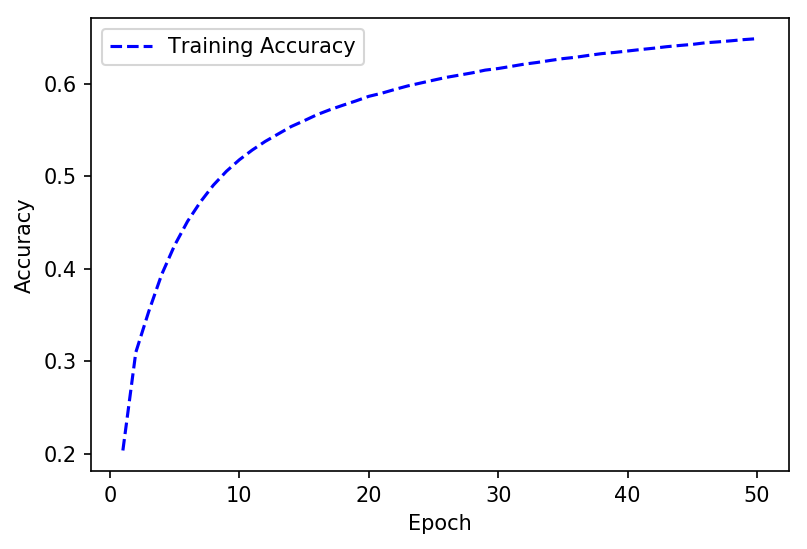

In [0]:
# Visualize loss history
#plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, training_acc, 'b--')
#plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

# Cross-validation

https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

In [0]:
import sklearn
from sklearn.model_selection import StratifiedKFold

sklearn.__version__

'0.20.3'

In [0]:
seed = 7
np.random.seed(seed)

folds = 5
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [0]:
epochs = 10
steps_per_epoch = 40
batch_size = 1024

learning_rate = 0.0001
loss = 'categorical_crossentropy'
opt = tf.train.AdamOptimizer(learning_rate)
model = modelDeeperCNN()
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

tpu_model = tf.contrib.tpu.keras_to_tpu_model(
    model,
    strategy=tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

INFO:tensorflow:Querying Tensorflow master (grpc://10.108.169.146:8470) for TPU system metadata.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, -1, 4384950252305678146)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 9165701345706545634)
INFO:tensorflow:*** Available Device: _DeviceAt

In [0]:
initial_weights = tpu_model.get_weights()

In [0]:
i = 1

print(cifar_train_norm.shape)
print(cifar_train_labels.shape)

epochs = 200
steps_per_epoch = 40
batch_size = 1024
learning_rate = 0.0001
loss = 'categorical_crossentropy'

for train_indices, test_indices in kfold.split(cifar_train_norm, cifar_train_labels_sparse):
  print("Cross-validation fold", i)
  i+=1
  # get data
  cifar_train_norm_part = cifar_train_norm[train_indices]
  cifar_train_labels_sparse_part = cifar_train_labels_sparse[train_indices]
  cifar_train_labels_part = to_categorical(cifar_train_labels_sparse_part)
  
  cifar_test_norm_part = cifar_train_norm[test_indices]
  cifar_test_labels_sparse_part = cifar_train_labels_sparse[test_indices]
  cifar_test_labels_part = to_categorical(cifar_test_labels_sparse_part)
  
  #print(cifar_train_norm_part.shape)
  #print(cifar_train_labels_part.shape)
  #print(cifar_test_norm_part.shape)
  #print(cifar_test_labels_part.shape)

  
  def train_input_fn_cv(batch_size=1024):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((cifar_train_norm_part, cifar_train_labels_part))

    # Shuffle, repeat, and batch the examples.
    dataset = dataset.cache()
    dataset = dataset.shuffle(1000, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

  # reset weights
  tpu_model.set_weights(initial_weights)

  # regen model
  # opt = tf.train.AdamOptimizer(learning_rate)
  # model = modelDeeperCNN()
  # model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
  # tpu_model = tf.contrib.tpu.keras_to_tpu_model(
  #   model,
  #   strategy=tf.contrib.tpu.TPUDistributionStrategy(
  #       tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))

  # retrain
  history = tpu_model.fit(train_input_fn_cv, steps_per_epoch=steps_per_epoch, epochs=epochs)
  print("---------------------")
  tpu_model.evaluate(cifar_test_norm_part, cifar_test_labels_part, batch_size=batch_size)
  print("============================")


(50000, 32, 32, 3)
(50000, 10)
Cross-validation fold 1
Epoch 1/200
INFO:tensorflow:New input shapes; (re-)compiling: mode=train (# of cores 8), [TensorSpec(shape=(1024,), dtype=tf.int32, name=None), TensorSpec(shape=(1024, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(1024, 10), dtype=tf.float32, name=None)]
INFO:tensorflow:Overriding default placeholder.
INFO:tensorflow:Remapping placeholder for conv2d_input
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Started compiling
INFO:tensorflow:Finished compiling. Time elapsed: 4.627600431442261 secs
INFO:tensorflow:Setting weights on TPU model.
40/40 [==============================] - 13s 333ms/step - loss: 2.2028 - acc: 0.1792
Epoch 2/200
40/40 [==============================] - 3s 67ms/step - loss: 1.8846 - acc: 0.3142
Epoch 3/200
40/40 [==============================] - 3s 67ms/step - loss: 1.7068 - acc: 0.3825
Epoch 4/200
40/40 [==============================